<a href="https://colab.research.google.com/github/bereml/iap/blob/master/libretas/2a_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de MNIST con un red convolucional

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En esta libreta veremos un ejemplo de clasificación multiclase de imágenes de dígitos implementando una red densa multicapa en PyTorch.

Emplearemos un conjunto referencia llamado [MNIST](http://yann.lecun.com/exdb/mnist/) recolectado por [Yann LeCun](http://yann.lecun.com). Está compuesto de imágenes en escala de grises de 28 × 28 píxeles que contienen dígitos entre 0 y 9 escritos a mano. El conjunto cuenta con 60,000 imágenes de entrenamiento y 10,000 de prueba.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="600"/>
Conjunto MNIST. Imagen tomada de Wikipedia.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

In [3]:
# parche para bicho en colab
# https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

### 1.2 Auxiliares

In [4]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_pipeline.png"/>
&nbsp;
Tuberia de datos para MNIST.

### 2.2 Cargadores de datos

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


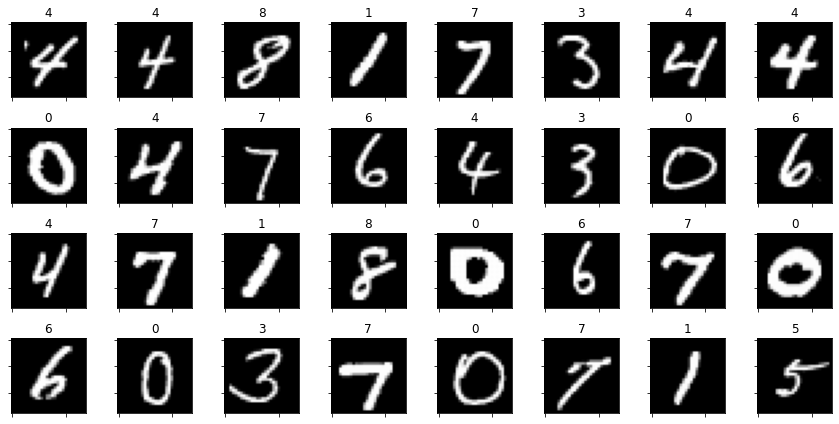

In [5]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = MNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm,
    # descaraga
    download=True
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


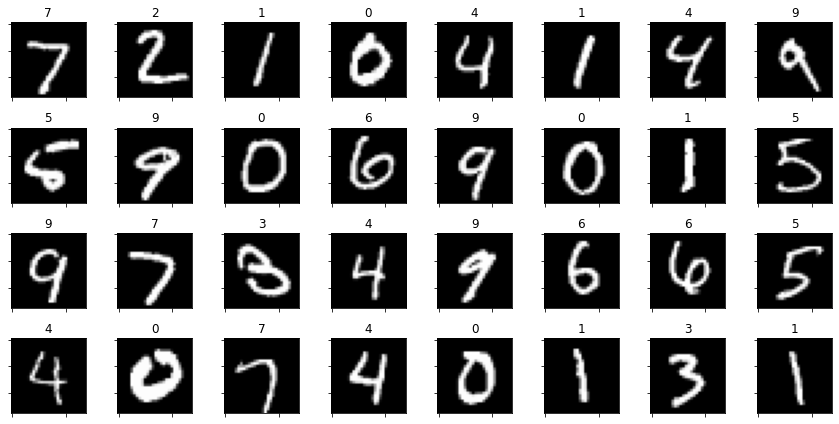

In [6]:
# creamos un Dataset
tst_ds = MNIST(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=False
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/mnist_cnn1.svg" width="300"/>

### 3.1 Definición de la arquitectura

In [7]:
# definición del arquitectura
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 4 * 14 * 14

        # definición de bloques conv
        # [N, 1, 28, 28] => [N, 4, 14, 14]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [N, 1, 28, 28] => [N, 4, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            # [N, 4, 28, 28]
            nn.ReLU(),
            # [N, 4, 28, 28] => [N, 4, 14, 14]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        
        # [N, 4, 14, 14] => [N, 4x14x14]
        self.flatten = nn.Flatten()

        # [N, 4x14x14] => [N, 1]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [N, 1, 28, 28] => [N, 4, 14, 14]
        x = self.cnn(x)
        # [N, 4, 14, 14] => [N, 4x14x14]
        x = self.flatten(x)
        # [N, 4x14x14] => [N, 10]
        x = self.cls(x)
        return x

### 3.2 Instancia de la arquitectura

In [8]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=784, out_features=10, bias=True)
)


In [9]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


### 3.3 Inspección de la arquitectura

In [10]:
summary(model, (1, 1, 28, 28), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 4, 14, 14]            --
|    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
|    └─ReLU: 2-2                         [1, 4, 28, 28]            --
|    └─MaxPool2d: 2-3                    [1, 4, 14, 14]            --
├─Flatten: 1-2                           [1, 784]                  --
├─Linear: 1-3                            [1, 10]                   7,850
Total params: 7,890
Trainable params: 7,890
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.03
Estimated Total Size (MB): 0.06

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/supervisado.svg" width="700"/>
&nbsp;
Ciclo de entrenamiento supervisado.

### 4.1 Ciclo de entrenamiento

In [11]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamos un modelo:

In [12]:
# instanciamos un modelo
model = CNN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:22<07:08, 22.56s/it]

E00 loss=[192.48,191.55] acc=[65.15,67.08]


 10%|█         | 2/20 [00:45<06:51, 22.83s/it]

E01 loss=[ 69.97, 67.33] acc=[83.52,84.47]


 15%|█▌        | 3/20 [01:04<05:57, 21.02s/it]

E02 loss=[ 47.13, 44.72] acc=[87.05,87.95]


 20%|██        | 4/20 [01:23<05:25, 20.33s/it]

E03 loss=[ 40.68, 38.49] acc=[88.37,89.11]


 25%|██▌       | 5/20 [01:45<05:10, 20.72s/it]

E04 loss=[ 37.63, 35.59] acc=[89.06,89.81]


 30%|███       | 6/20 [02:04<04:43, 20.23s/it]

E05 loss=[ 35.84, 33.80] acc=[89.53,90.25]


 35%|███▌      | 7/20 [02:23<04:19, 19.97s/it]

E06 loss=[ 34.76, 32.69] acc=[89.78,90.72]


 40%|████      | 8/20 [02:42<03:54, 19.53s/it]

E07 loss=[ 33.63, 31.80] acc=[90.21,90.92]


 45%|████▌     | 9/20 [03:00<03:30, 19.13s/it]

E08 loss=[ 32.93, 31.11] acc=[90.36,91.12]


 50%|█████     | 10/20 [03:21<03:18, 19.80s/it]

E09 loss=[ 32.31, 30.64] acc=[90.59,91.21]


 55%|█████▌    | 11/20 [03:40<02:53, 19.26s/it]

E10 loss=[ 31.85, 30.18] acc=[90.69,91.35]


 60%|██████    | 12/20 [03:58<02:31, 18.88s/it]

E11 loss=[ 31.39, 29.89] acc=[90.86,91.37]


 65%|██████▌   | 13/20 [04:16<02:12, 18.88s/it]

E12 loss=[ 31.06, 29.52] acc=[90.90,91.43]


 70%|███████   | 14/20 [04:34<01:51, 18.56s/it]

E13 loss=[ 30.78, 29.35] acc=[91.01,91.44]


 75%|███████▌  | 15/20 [04:55<01:35, 19.10s/it]

E14 loss=[ 30.50, 29.15] acc=[91.18,91.52]


 80%|████████  | 16/20 [05:16<01:18, 19.68s/it]

E15 loss=[ 30.24, 28.79] acc=[91.17,91.67]


 85%|████████▌ | 17/20 [05:35<00:58, 19.49s/it]

E16 loss=[ 30.04, 28.66] acc=[91.18,91.68]


 90%|█████████ | 18/20 [05:54<00:38, 19.36s/it]

E17 loss=[ 29.76, 28.38] acc=[91.39,91.77]


 95%|█████████▌| 19/20 [06:13<00:19, 19.43s/it]

E18 loss=[ 29.56, 28.43] acc=[91.46,91.85]


100%|██████████| 20/20 [06:32<00:00, 19.65s/it]

E19 loss=[ 29.55, 28.51] acc=[91.47,91.81]


### 4.2 Gráficas de pérdidas y exactitud

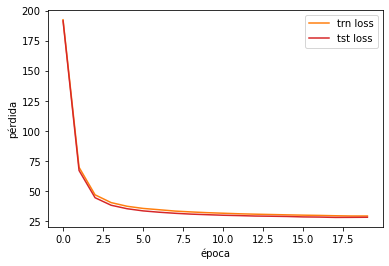

In [13]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

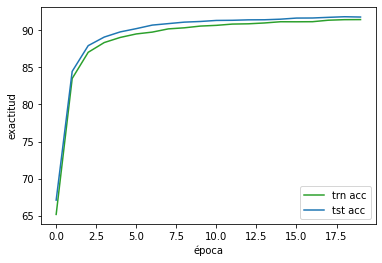

In [14]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/bereml/iap/master/fig/eval_trn_tst.svg" width="450"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Evaluación final

In [15]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 29.55, 28.51] acc=[91.47,91.81]


### 5.2 Inferencia

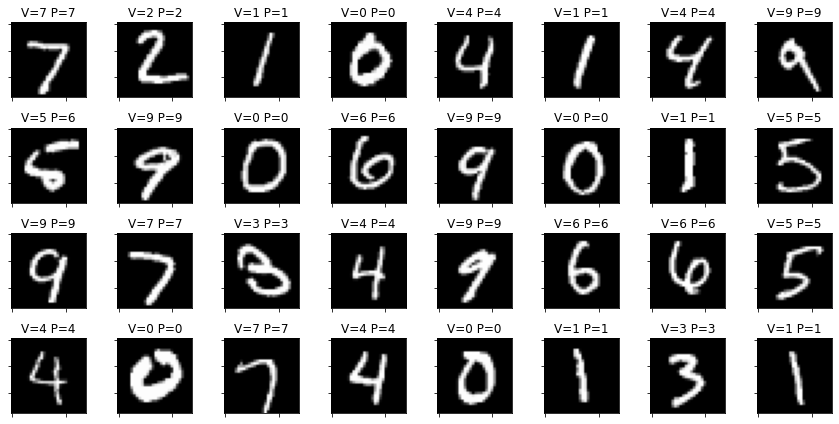

In [16]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)